# Lab 1: Spike Sorting

**STATS320: Machine Learning Methods for Neural Data Analysis**

_Stanford University. Winter, 2023._

---

**Team Name:** _Your team name here_

**Team Members:** _Names of everyone on your team here_

*Due: 11:59pm Thursday, Jan 26, 2023 via GradeScope (see below)*

---

This lab implements a convolutional matrix factorization model that is similar to [Kilosort](https://github.com/MouseLand/Kilosort), a state-of-the-art spike sorting package. We'll use PyTorch to implement the key operations&mdash;convolutions and cross-correlations&mdash;on a GPU. We'll test it on a small synthetic dataset first and then try it on a realistic dataset.

## Environment Setup

In [1]:
%%capture
# Download some synthetic data for part 4 and solutions to check your code
!wget -nc https://www.dropbox.com/s/sg3pmrqu7wafqb7/lab1_data.pt
!wget -nc https://www.dropbox.com/s/8yal89r2ljr8ise/lab1_solutions.pt

In [2]:
# Import PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

# We'll use a few functions from scipy
from scipy.signal import find_peaks
from scipy.optimize import linear_sum_assignment

# Plotting stuff
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Some helper utilities
from tqdm.auto import trange

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print('WARNING: THIS LAB IS BEST PERFORMED ON A MACHINE WITH A GPU!')
    print('WARNING: IF USING COLAB, PLEASE SELECT A GPU RUNTIME!')

In [4]:
# Load the solutions so you can check your answers
# NOTE: the solutions were generated with a GPU runtime
# If you try to load them on a CPU, it will fail. You would 
# need to map the cuda device to the cpu.
solutions = torch.load("lab1_solutions.pt")

## Helper Functions

In [12]:
#@title Helper functions for plotting (run this cell)

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])
sns.set_context("notebook")


def plot_data(timestamps,
              data, 
              plot_slice=slice(0, 6000), 
              labels=None, 
              spike_times=None,
              neuron_channels=None,
              spike_width=81,
              scale=10,
              figsize=(12, 9),
              cmap="jet"):
    n_channels, n_samples = data.shape
    cmap = get_cmap(cmap) if isinstance(cmap, str) else cmap
    
    plt.figure(figsize=figsize)
    plt.plot(timestamps[plot_slice], 
             data.T[plot_slice] - scale * torch.arange(n_channels), 
             '-k', lw=1)
    
    if not any(x is None for x in [labels, spike_times, neuron_channels]):
        # Plot the ground truth spikes and assignments
        n_units = labels.max()
        in_slice = (spike_times >= plot_slice.start) & (spike_times < plot_slice.stop)
        labels = labels[in_slice]
        times = spike_times[in_slice]
        for i in range(n_units):
            i_channels = neuron_channels[i]
            for t in times[labels == i]:
                window = slice(t, t + spike_width)
                plt.plot(timestamps[window], 
                         data.T[window, i_channels] - scale * torch.arange(n_channels)[i_channels],
                         color=cmap(i / (n_units-1).numpy()),
                         alpha=0.5,
                         lw=2)
                
    plt.yticks(-scale * torch.arange(1, n_channels+1, step=2).numpy(), 
               torch.arange(1, n_channels+1, step=2).numpy() + 1)
    plt.xlabel("time [s]")
    plt.ylabel("channel")
    plt.xlim(timestamps[plot_slice.start], timestamps[plot_slice.stop])
    plt.ylim(-scale * n_channels, scale)


def plot_templates(templates, 
                   indices,
                   scale=0.1,
                   n_cols=8,
                   panel_height=6,
                   panel_width=1.25,
                   colors=('k',),
                   label="neuron",
                   sample_freq=30000,
                   fig=None,
                   axs=None):
    n_subplots = len(indices)
    n_cols = min(n_cols, n_subplots)
    n_rows = int(torch.ceil(torch.tensor(n_subplots / n_cols)))

    if fig is None and axs is None:
        fig, axs = plt.subplots(n_rows, n_cols, 
                                figsize=(panel_width * n_cols, panel_height * n_rows),
                                sharex=True, sharey=True)
    
    n_units, n_channels, spike_width = templates.shape
    timestamps = torch.arange(-spike_width // 2, spike_width//2) / sample_freq
    for i, ind in enumerate(indices):
        row, col = i // n_cols, i % n_cols
        ax = axs[row, col] if n_rows > 1 else axs[col]
        color = colors[i % len(colors)]
        ax.plot(timestamps * 1000, 
                templates[ind].T - scale * torch.arange(n_channels), 
                '-', color=color, lw=1)
        
        ax.set_title("{} {:d}".format(label, ind + 1))
        ax.set_xlim(timestamps[0] * 1000, timestamps[-1] * 1000)
        ax.set_yticks(-scale * torch.arange(0, n_channels+1, step=4))
        ax.set_yticklabels(torch.arange(0, n_channels+1, step=4).numpy() + 1)
        ax.set_ylim(-scale * n_channels, scale)

        if i // n_cols == n_rows - 1:
            ax.set_xlabel("time [ms]")
        if i % n_cols == 0:
            ax.set_ylabel("channel")

        # plt.tight_layout(pad=0.1)

    # hide the remaining axes
    for i in range(n_subplots, len(axs)):
        row, col = i // n_cols, i % n_cols
        ax = axs[row, col] if n_rows > 1 else axs[col]
        ax.set_visible(False)

    return fig, axs


def plot_model(templates, amplitude, data, scores=None, lw=2, figsize=(12, 6)):
    """Plot the raw data as well as the underlying signal amplitudes and templates.
    
    amplitude: (K,T) array of underlying signal amplitude
    template: (K,N,D) array of template that is convolved with signal
    data: (N, T) array (channels x time)
    scores: optional (K,T) array of correlations between data and template
    """    
    # prepend dimension if data and template are 1d
    data = torch.atleast_2d(data)
    N, T = data.shape
    amplitude = torch.atleast_2d(amplitude)
    K, _ = amplitude.shape
    templates = templates.reshape(K, N, -1)
    D = templates.shape[-1]
    dt = torch.arange(D)
    if scores is not None:
        scores = torch.atleast_2d(scores)

    # Set up figure with 2x2 grid of panels
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, K + 1, height_ratios=[1, 2], width_ratios=[1] * K + [2 * K])

    # plot the templates
    t_spc = 1.05 * abs(templates).max()
    for n in range(K):
        ax = fig.add_subplot(gs[1, n])
        ax.plot(dt, templates[n].T - t_spc * torch.arange(N), 
                '-', color=palette[n % len(palette)], lw=lw)
        ax.set_xlabel("delay $d$")
        ax.set_xlim([0, D])
        ax.set_yticks(-t_spc * torch.arange(N))
        ax.set_yticklabels([])
        ax.set_ylim(-N * t_spc, t_spc)
        if n == 0:
            ax.set_ylabel("channels $n$")
        ax.set_title("$W_{{ {} }}$".format(n+1))

    # plot the amplitudes for each neuron
    ax = fig.add_subplot(gs[0, -1])
    a_spc = 1.05 * abs(amplitude).max()
    if scores is not None:
        a_spc = max(a_spc, 1.05 * abs(scores).max())

    for n in range(K):
        ax.plot(amplitude[n] - a_spc * n, '-', color=palette[n % len(palette)], lw=lw)
        
        if scores is not None:
            ax.plot(scores[n] - a_spc * n, ':', color=palette[n % len(palette)], lw=lw,
                label="$X \star W$")
        
    ax.set_xlim([0, T])
    ax.set_xticklabels([])
    ax.set_yticks(-a_spc * torch.arange(K).numpy())
    ax.set_yticklabels([])
    ax.set_ylabel("neurons $k$")
    ax.set_title("amplitude $a$")
    if scores is not None:
        ax.legend()

    # plot the data
    ax = fig.add_subplot(gs[1, -1])
    d_spc = 1.05 * abs(data).max()
    ax.plot(data.T - d_spc * torch.arange(N), '-', color='gray', lw=lw)
    ax.set_xlabel("time $t$")
    ax.set_xlim([0, T])
    ax.set_yticks(-d_spc * torch.arange(N).numpy())
    ax.set_yticklabels([])
    ax.set_ylim(-N * d_spc, d_spc)
    # ax.set_ylabel("channels $c$")
    ax.set_title("data $\mathbb{E}[X]$")

    # plt.tight_layout()

In [13]:
#@title Helper function to generate synthetic data (run this cell)

def generate_templates(num_channels, len_waveform, num_neurons):
    # Make (semi) random templates
    templates = []
    for k in range(num_neurons):
        center = dist.Uniform(0.0, num_channels).sample()
        width = dist.Uniform(1.0, 1.0 + num_channels / 10.0).sample()
        spatial_factor = torch.exp(-0.5 * (torch.arange(num_channels) - center)**2 / width**2)
        
        dt = torch.arange(len_waveform)
        period = len_waveform / (dist.Uniform(1.0, 2.0).sample())
        z = (dt - 0.75 * period) / (.25 * period)
        warp = lambda x: -torch.exp(-x) + 1
        window = torch.exp(-0.5 * z**2)
        shape = torch.sin(2 * torch.pi * dt / period)
        temporal_factor = warp(window * shape)

        template = torch.outer(spatial_factor, temporal_factor)
        template /= torch.linalg.norm(template)
        templates.append(template)
    
    return torch.stack(templates)
    

def generate(num_timesteps, 
             num_channels, 
             len_waveform, 
             num_neurons, 
             mean_amplitude=15,
             shape_amplitude=3.0,
             noise_std=1, 
             sample_freq=1000):
    """Create a random set of model parameters and sample data.

    Parameters:
    num_timesteps: integer number of time samples in the data
    num_channels: integer number of channels
    len_waveform: integer duration (number of samples) of each template
    num_neurons: integer number of neurons
    """    
    # Make semi-random templates
    templates = generate_templates(num_channels, len_waveform, num_neurons)

    # Make random amplitudes
    amplitudes = torch.zeros((num_neurons, num_timesteps))
    for k in range(num_neurons):
        num_spikes = dist.Poisson(num_timesteps / sample_freq * 10.0).sample()
        sample_shape = (1 + int(num_spikes),)
        times = dist.Categorical(torch.ones(num_timesteps) / num_timesteps).sample(sample_shape)
        amps = dist.Gamma(shape_amplitude, shape_amplitude / mean_amplitude).sample(sample_shape)
        amplitudes[k, times] = amps

        # Only keep spikes separated by at least D
        times, props = find_peaks(amplitudes[k], distance=len_waveform, height=1e-3)
        amplitudes[k] = 0
        amplitudes[k, times] = torch.tensor(props['peak_heights'], dtype=torch.float32)

    # Convolve the signal with each row of the multi-channel template
    data = F.conv1d(amplitudes.unsqueeze(0),
                    templates.permute(1, 0, 2).flip(dims=(2,)),
                    padding=len_waveform-1)[0, :, :-(len_waveform-1)]
    
    data += dist.Normal(0.0, noise_std).sample(data.shape)

    return templates, amplitudes, data


## Part 1: Convolution and cross-correlation with PyTorch

One of the main advantages of PyTorch over Numpy/Scipy is that it allows us to use hardware accelerators like GPUs. PyTorch tensors are stored on a specified device, and in the setup above you'll see that we specified our device to be `'cuda'`, i.e. a GPU. Google Colab gives you free access to a GPU machine, as long as you select the GPU runtime. If you click the RAM/disk icon in the upper right, you should see that this session is a GPU session. If it's not, go to "Runtime -> Change Runtime Type" to select a GPU.

`Tensor` objects have a few nice functions that will make your life easier in this lab. Suppose `data` is a `Tensor`. Then,
- `data.flip(dims=(-1,))` flips the tensor along its last axis.
- `data.unsqueeze(0)` creates a new leading axis.
- `data.permute(1, 0, 2)` permutes the order of the axes.
- `data.reshape(1, 1, -1)` vectorizes the data and reshapes it to have two leading dimensions, each of length 1.
- `data.sum()` sums the entries in the data.

If this is your first time using PyTorch and you get stuck, you might want to go back to [Lab 0: PyTorch Primer](labs/00_pytorch_primer.ipynb).


### Problem 1a: Perform a 1d convolution

As a first step, we generate synthetic data with a single neuron and a single channel. Based on a template and a 1d array representing amplitudes for the single neuron, we simulate data as the convolution of these two arrays. 

You'll use the `conv1d` function in the `torch.nn.functional` package. We've already imported that package with the shorthand name `F` so that you can call the function with `F.conv1d(...)`. Take a look at its documentation [here](https://pytorch.org/docs/stable/nn.functional.html?highlight=conv1d#torch.nn.functional.conv1d), as well as the corresponding documentation for the `torch.nn.Conv1d` object, which implements a convolutional layer for a neural network. 

Here's an example,
```
# make the input (i.e. the signal)
B = 1   # batch size
K = 2   # number of input channels
T = 100 # length of input signal
input = torch.rand(B, K, T)

# make the weights (i.e. the filter)
N = 3   # number of output channels
D = 10  # length of the filter
weight = torch.rand(N, K, D)

# perform the convolution
output = F.conv1d(input, weight)

# output.shape is (B, N, T - D + 1)
```
**Remember that `conv1d` actually performs a cross-correlation!** 

Let $\mathbf{A} \in \mathbb{R}^{B \times K \times T}$ denote the signal/input and $\mathbf{W} \in \mathbb{R}^{N \times K \times D}$ denote the filter/weights (note that the axes are permuted relative to our mathematical notes), and let $\mathbf{X} \in \mathbb{R}^{B \times N \times T - D + 1}$ denote the output. Then the `conv1d` function implements the cross-correlation, 

$$
\begin{align*}
x_{b,n,t} = \sum_{k = 1}^{K} \sum_{d=1}^D a_{b,k,t+d-1} w_{n,k,d}.
\end{align*}
$$

for $b=1,\ldots,B$, $n=1,\ldots,N$, and $t=1,\ldots,T-D+1$. 

By default the output only contains the "valid" portion of the convolution; i.e. the $T-D+1$ samples where the inputs and weights completely overlap. If you want the "full" output, you have to call `F.conv1d(input, weights, padding=D-1)`. This pads the input with $D-1$ zeros at the beginning and end so that the resulting output is length $T + D - 1$. Depending your application, you may want the first $T$ or the last $T$ entries in this array. When in doubt, try both and see!

Use `conv1d` to implement a 1d **convolution**. Remember that you can do it by cross-correlation as long as you flip your weights along the last axis. 

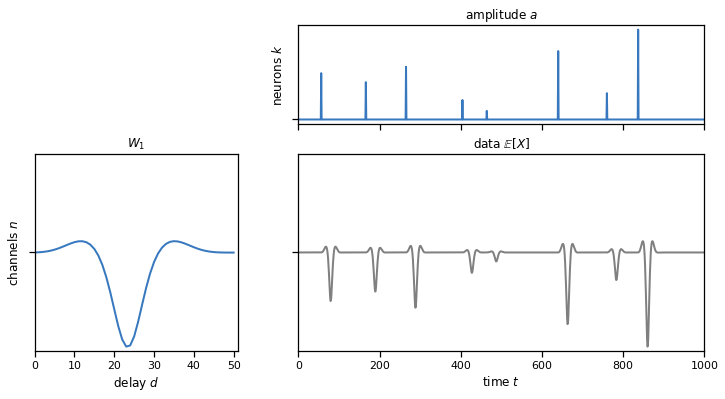

In [14]:
# Create a dataset with a single channel and one neuron.
T = 1000    # number of time samples
K = 1       # one neuron
N = 1       # number of channels
D = 51      # duration of a spike (in samples)

# Generate random templates, amplitudes, and noisy data.
# `templates` are KxNxD and `amplitudes` are KxT
torch.manual_seed(2)
templates, amplitudes, _ = generate(T, N, D, K)

###
# Now perform the same convolution using PyTorch's `conv1d` function.
# YOUR CODE BELOW

# data = F.conv1d(...)

#
##

# Your answer should look like this
plot_model(templates, amplitudes, solutions["1a"])
assert torch.allclose(data, solutions["1a"], atol=1e-4)

### Problem 1b: Perform a 1d cross-correlation in PyTorch

Remember that the cross-correlation measures the similarity between the template and the actual data at every time window. In those time points where the data and the template coincide, we should obtain a high correlation indicating the presence of a spike. The peaks of the amplitude array and the cross-correlation array should match, as you see in the plot below.  The dotted line shows the cross-correlation of the data and the template, and we see that it peaks where there are spikes in the true underlying amplitude that generated the data. 

Use `conv1d` to implement this **cross-correlation** and get the dotted line. 

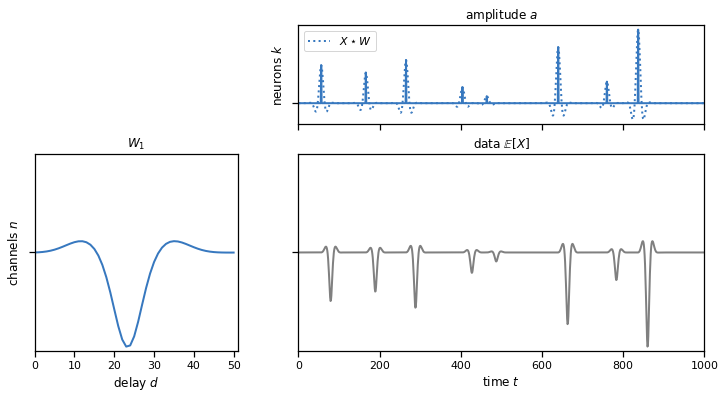

In [15]:
###
# Perform the cross-correlation using PyTorch's `conv1d` function.
# YOUR CODE BELOW

# score = F.conv1d(...)

#
##

# Your answer should look like this
plot_model(templates, amplitudes, data, scores=solutions["1b"])
assert torch.allclose(score, solutions["1b"], atol=1e-4)

### Problem 1c: Perform a 1d convolution across multiple channels at once

Similar to problem 1a, except that the template (and therefore the final synthetic data) has multiple _output_ channels.

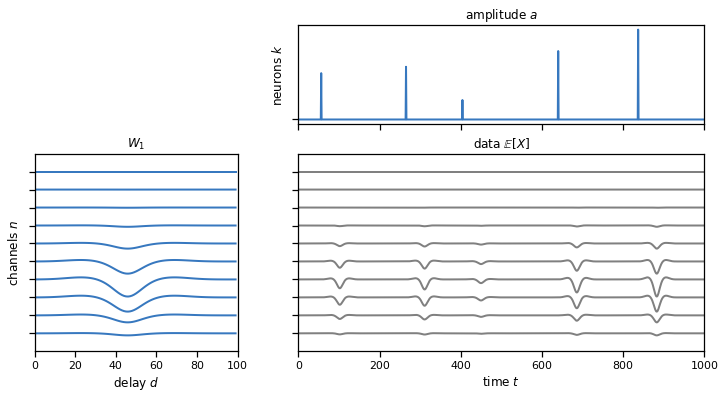

In [16]:
# Create a dataset with a many channels but one neuron.
T = 1000    # number of time samples
N = 10      # number of channels
D = 100     # duration of a spike (in samples)
K = 1       # one neuron

# Generate random templates, amplitudes, and noisy data.
# `templates` are KxNxD and `amplitudes` are KxT
torch.manual_seed(2)
templates, amplitudes, _ = generate(T, N, D, K)

###
# Now perform the same convolution using PyTorch's `conv1d` function.
# YOUR CODE BELOW

# data = F.conv1d(...)

###

# Your solution shold look like this 
plot_model(templates, amplitudes, solutions["1c"])
assert torch.allclose(data, solutions["1c"], atol=1e-4)

### Problem 1d: Perform a 1d cross-correlation across multiple channels at once

Same as Problem 1b except that the data and templates have multiple _input_ channels.

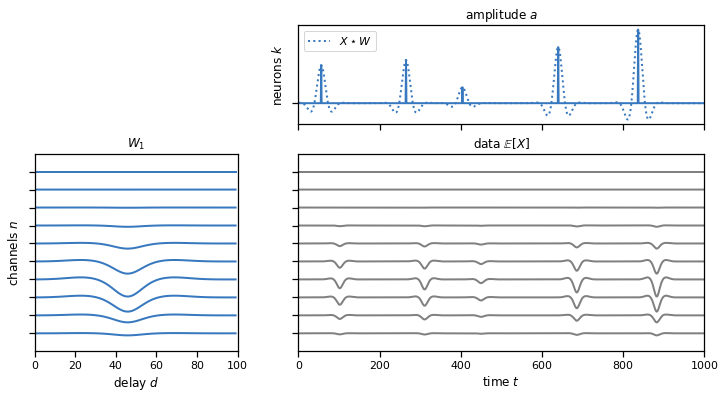

In [17]:
###
# Perform the cross-correlation using PyTorch's 
# ``nn.functional.conv1d` function. You should only need 
# one call to this function!
#
# YOUR CODE BELOW
# score = F.conv1d(...)

### 

plot_model(templates, amplitudes, data, scores=solutions["1d"])
assert torch.allclose(score, solutions["1d"], atol=1e-4)

### Problem 1e: Convolving multiple neurons' spikes and templates

Similar to problem 1c, but here we have multiple neurons (input channels), each associated to a template with multiple (output) channels. The final simulated data is aggregated across neurons to simulate actual measurements where signals from multiple neurons are superimposed.

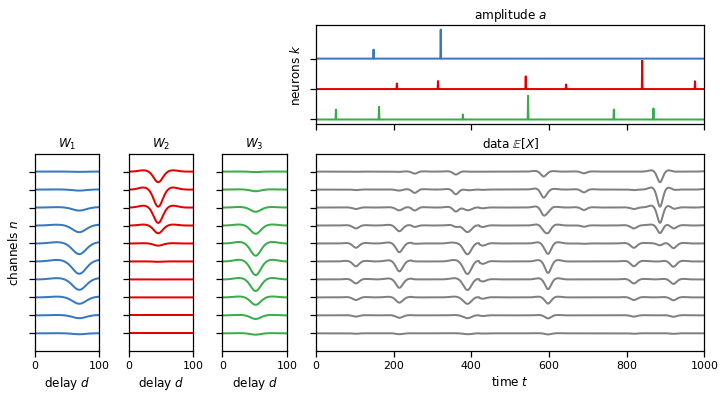

In [18]:
# Create a dataset with a multiple channels and neurons.
T = 1000    # number of time samples
N = 10      # number of channels
D = 100     # duration of a spike (in samples)
K = 3       # multiple neuron

# Generate random templates, amplitudes, and noisy data.
# `templates` are KxNxD and `amplitudes` are KxT
torch.manual_seed(0)
templates, amplitudes, _ = generate(T, N, D, K)

###
# Perform the convolution using PyTorch's `conv1d` function. 
# One call to `F.conv1d` should perform the sum over neurons for you.
# YOUR CODE BELOW

# data = F.conv1d(...)

###

plot_model(templates, amplitudes, solutions["1e"])
assert torch.allclose(data, solutions["1e"], atol=1e-4)

### Problem 1f: Perform a 1d cross-correlation across multiple channels and neurons at once

Same as Problem 1c but now we're performing the cross-correlation with multiple neurons' templates at once.

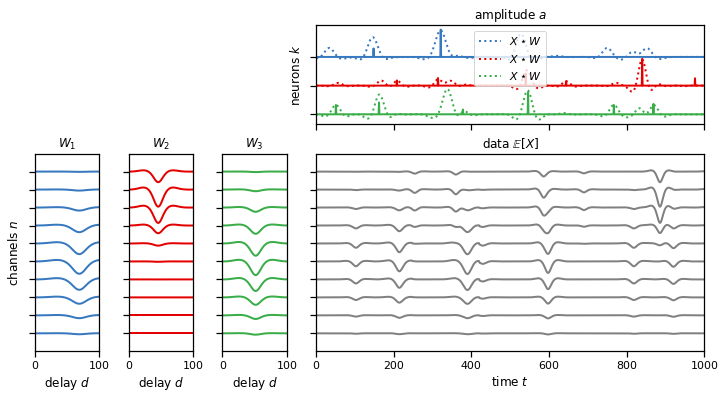

In [19]:
###
# Perform the convolution using PyTorch's `conv1d` function. 
# One call to `F.conv1d` should perform all cross-correlations for you.
# YOUR CODE BELOW
#

# score = F.conv1d(...)

###

# Your answer should look like this
plot_model(templates, amplitudes, data, scores=solutions["1f"])
assert torch.allclose(score, solutions["1f"], atol=1e-4)

## Part 2: Spike sorting by deconvolution

In this part of the lab you'll use those cross-correlation and convolution operations to implement the spike sorting algorithm we discussed in class. We'll work with a synthetic dataset, as above, but this time we'll make it slightly larger.  (It's still a lot smaller than the dataset we used in Lab 1 though!)

### Simulate some data

No coding necessary here. We're just simulating the data for you.

Simulating data. This could take a few seconds!


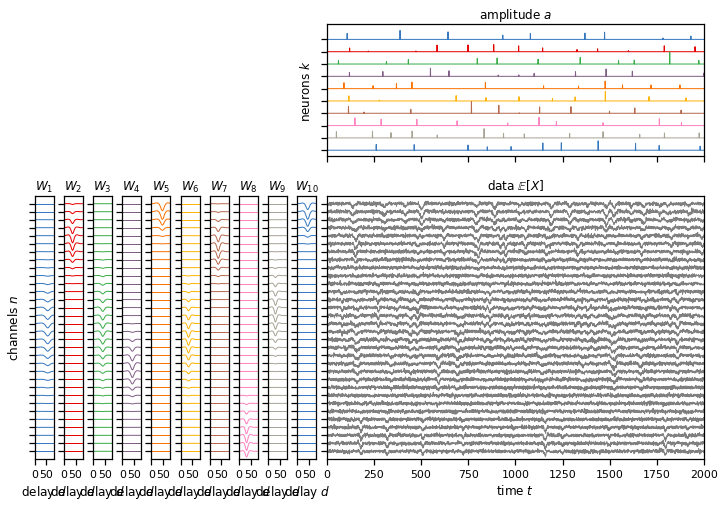

In [20]:
# Create a larger dataset with a multiple channels and neurons.
T = 1000000 # number of time samples
N = 32      # number of channels
D = 81      # duration of a spike (in samples)
K = 10      # multiple neurons

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
torch.manual_seed(0)
print("Simulating data. This could take a few seconds!")
true_templates, true_amplitudes, data = generate(T, N, D, K)
plot_model(true_templates, true_amplitudes[:, :2000], data[:,:2000], 
           lw=1, figsize=(12, 8))

In [21]:
# Generate another set of random templates and amplitudes to seed the model
torch.manual_seed(1)
templates = generate_templates(N, D, K)
amplitudes = torch.zeros((K, T))
noise_std = 1.0

# Copy the tensors to the GPU (if available)
templates = templates.to(device)
amplitudes = amplitudes.to(device)
data = data.to(device)

### Problem 2a: Compute the log likelihood

One of the most awesome features of PyTorch is its `torch.distributions` package. See the docs [here](https://pytorch.org/docs/stable/distributions.html). It contains objects for many of our favorite distributions, and has convenient functions for computing log probabilities (with `d.log_prob()` where `d` is a `Distribution` object), sampling (`d.sample()`), computing the entropy (`d.entropy()`), etc. These functions broadcast as you'd expect (unlike `scipy.stats`!), and they're designed to work with automatic differentiation.  More on that another day...

For now, you'll use `dist.Normal` to compute the log likelihood of the data given the template and amplitudes, $\log p(\mathbf{X} \mid \mathbf{A}, \mathbf{W})$.  To do that, you'll convolve the amplitudes and templates (recall Problem 1e) to get the mean value of $\mathbf{X}$, then you'll use the `log_prob` function to evaluate the likelihood of the data.

In [22]:
def log_likelihood(templates, amplitudes, data, noise_std):
    """Evaluate the log likelihood"""
    K, N, D = templates.shape
    _, T = data.shape
    
    ### 
    # YOUR CODE BELOW
    
    # Compute the model prediction by convolving the amplitude and templates
    # pred = F.conv1d(...)

    # Evaluate the log probability using dist.Normal
    # ll = ...
    
    ###  

    # Return the log probability normalized by the data size
    return ll / (N * T)

ll = log_likelihood(templates, amplitudes, data, noise_std)
assert ll.isclose(solutions["2a"], atol=1e-4)

### Problem 2b: Compute the residual

Next, compute the residual for a specified neuron by subtracting the convolved amplitudes and templates for all the other neurons. Again, recall Problem 1e.

In [23]:
def compute_residual(neuron, templates, amplitudes, data):
    K, C, D = templates.shape

    ###
    # Compute the predicted value of the data by 
    # convolving the amplitudes and the templates for all
    # neurons except the specified one.
    #
    # YOUR CODE BELOW
    not_n = torch.cat([torch.arange(neuron), torch.arange(neuron+1, K)])
    # pred = F.conv1d(...)
    
    ###

    # Return the data minus the predicted value given other neurons
    return data - pred

residual = compute_residual(0, templates, amplitudes, data)
assert residual[16, [0, 1234, -1]].allclose(solutions["2b"], atol=1e-4)

### Problem 2c: Compute the score

Let the "score" for neuron $k$ be the cross-correlation of the residual and its template. Compute it using `conv1d`. Recall Problem 1d.

In [24]:
def compute_score(neuron, templates, amplitudes, data):
    K, N, D = templates.shape
    T = data.shape[1]

    # First get the residual
    residual = compute_residual(neuron, templates, amplitudes, data)

    ###
    # YOUR CODE BELOW
    # score = F.conv1d(...)
    ###
        
    return score

score = compute_score(0, templates, amplitudes, data)
assert score[[0, 1234, -1]].allclose(solutions["2c"], atol=1e-4)

### Problem 2d: Update the amplitudes using `find_peaks`

Our next step is to update the amplitudes given the scores. We'll use a simple heuristic as described in the course notes: use `find_peaks` to find peaks in the score that are separated by a distance of at least $D$ samples and at least a height of $\sigma^2 \lambda$, where $\sigma$ is the standard deviation of the noise and $\lambda$ is the amplitude rate hyperparameter. 

In [25]:
def _update_amplitude(neuron, templates, amplitudes, data, 
                      noise_std=1.0, amp_rate=5.0):
    K, N, D = templates.shape
    T = data.shape[1]

    # Compute the score and convert it to a numpy array.
    score = compute_score(neuron, templates, amplitudes, data).to("cpu")
    
    # Initialize the new amplitudes a_k for this neuron
    new_amplitude = torch.zeros(T, device=device)
    
    ###
    # YOUR CODE BELOW
    
    # peaks, props = find_peaks(...)
    
    # Convert the peak heights to a tensor
    # heights = torch.tensor(props['peak_heights'], 
    #                        dtype=torch.float32, device=device)

    # Compute the new amplitude for this neuron.
    # new_amplitude...
    
    #
    ###
        
    return new_amplitude
    
amplitudes[0] = _update_amplitude(0, templates, amplitudes, data)
assert torch.allclose(amplitudes[0][[118, 119, 467, -1]].to("cpu"), 
                      solutions["2d"])

### Problem 2e: Update the templates 
Our last step is to update the template for a given neuron by projecting the _target_ $\overline{\mathbf{R}} \in \mathbb{R}^{N \times D}$. The target is the sum of scaled residuals at the times of spikes in the amplitudes:
\begin{align}
    \overline{\mathbf{R}} = \sum_t a_{k,t} \mathbf{R}_{:,t:t+D}.
\end{align}
where $\mathbf{R} \in \mathbb{R}^{N \times T}$ denotes the residual for neuron $n$. 

To get the template, project $\overline{\mathbf{R}}$ onto $\mathcal{S}_K^{(N,D)}$, the set of rank-$K$, unit-norm, $N \times D$ matrices, using the SVD. 

In [26]:
def _update_template(neuron, templates, amplitudes, data, template_rank=1):
    K, N, D = templates.shape
    T = data.shape[1]

    # Initialize the new template
    new_template = torch.zeros((N, D), device=device)

    # Check if the factor is used. If not, generate a random new one.
    if amplitudes[neuron].sum() < 1:
        target = generate_templates(N, D, 1)[0]

    else:
        # Get the residual using the function you wrote above
        residual = compute_residual(neuron, templates, amplitudes, data)

        ###
        # YOUR CODE BELOW
        # target = ...
        ###
        
    ###
    # Project the target onto the set of normalized rank-K templates using 
    # `torch.svd` and `torch.norm`. Note that `torch.svd` returns V rather 
    # than V^T
    # YOUR CODE BELOW
    
    # new_template = ...
    
    ###
    
    return new_template

# Set amplitudes using previous cell output
# so the template update code is executed
templates[0] = _update_template(0, templates, amplitudes, data)
assert torch.linalg.norm(templates[0], 'fro').isclose(
    torch.tensor(1.0), atol=1e-4)
assert templates[0][16, 44].isclose(solutions["2e"], atol=1e-4)

### Put it all together

That's it! We've written a little function to perform coordinate ascent using your `_update_*` functions. It tracks the log likelihood at each iteration. (We're ignoring the priors for now, but it would be easy to compute those in Problem 2a if you wanted to). It also uses some nice progress bars so you can see how fast (or slow?) your code runs.

In [28]:
def map_estimate(templates, 
                 amplitudes, 
                 data,
                 num_iters=20, 
                 template_rank=1,
                 noise_std=1.0, 
                 amp_rate=5.0,
                 tol=1e-4):
    """Fit the templates and amplitudes by maximum a posteriori (MAP) estimation
    """
    K, N, D = templates.shape

    # Make fancy reusable progress bars
    outer_pbar = trange(num_iters)
    inner_pbar = trange(K)
    inner_pbar.set_description("updating neurons")

    # Track log likelihoods over iterations
    lls = [log_likelihood(templates, amplitudes, data, noise_std=noise_std)]
    for itr in outer_pbar:
        inner_pbar.reset()
        for k in range(K):
            # Update the amplitude
            amplitudes[k] = _update_amplitude(
                k, templates, amplitudes, data, 
                noise_std=noise_std, amp_rate=amp_rate)    
            # Update the template
            templates[k] = _update_template(
                k, templates, amplitudes, data, template_rank=template_rank)
            inner_pbar.update()

        # Compute the log likelihood 
        lls.append(log_likelihood(templates, amplitudes, data, 
                                  noise_std=noise_std))

        # Check for convergence
        if abs(lls[-1] - lls[-2]) < tol:
            print("Convergence detected!")
            break
    
    return torch.stack(lls)

### Fit the synthetic data and plot the log likelihoods

In [29]:
# Make random templates and set amplitude to zero
torch.manual_seed(0)
templates = generate_templates(N, D, K)
amplitudes = torch.zeros((K, T), device=device)
noise_std = 1.0     # \sigma
amp_rate = 5.0      # \lambda

# Copy to the device
true_templates = true_templates.to(device)
true_amplitudes = true_amplitudes.to(device)
templates = templates.to(device)
amplitudes = amplitudes.to(device)
data = data.to(device)

# Fit the model.
lls = map_estimate(templates, amplitudes, data, 
                   noise_std=noise_std, 
                   amp_rate=amp_rate)

# For comparison, compute the log likelihood with the true templates 
# and amplitudes.
true_ll = log_likelihood(true_templates, true_amplitudes, data, noise_std)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Convergence detected!


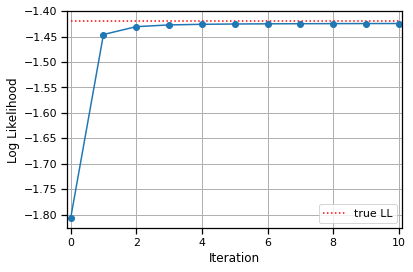

In [30]:
# Plot the log likelihoods
lls = lls.to("cpu")
true_ll = true_ll.to("cpu")

plt.plot(lls, '-o')
plt.hlines(true_ll, 0, len(lls) - 1, 
           colors='r', linestyles=':', label="true LL")
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.legend(loc="lower right")

### Find a permutation of the inferred neurons that best matches the true neurons

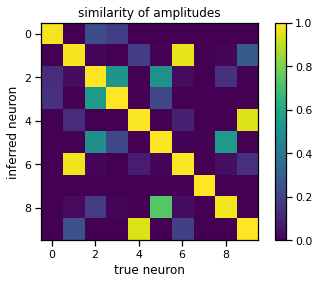

In [31]:
# Compute the similarity (inner product) of the true and inferred templates
similarity = torch.zeros((K, K))
for i in range(K):
    for j in range(K):
        similarity[i, j] = torch.sum(true_templates[i] * templates[j])
        
# Show the similarity matrix
_, perm = linear_sum_assignment(similarity, maximize=True)
plt.imshow(similarity[:, perm], vmin=0, vmax=1)
plt.xlabel("true neuron")
plt.ylabel("inferred neuron")
plt.title("similarity of amplitudes")
plt.colorbar()

### Plot the true and inferred templates

They should line up pretty well.

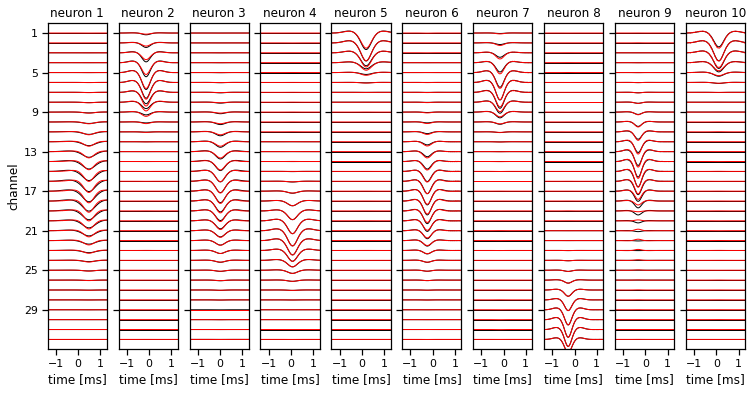

In [33]:
# Plot the true and inferred templates, permuted to best match
fig, axs = plot_templates(true_templates.to("cpu"), torch.arange(K), n_cols=K)
_ = plot_templates(templates[perm].to("cpu"), 
                   torch.arange(K), 
                   n_cols=K, 
                   colors=('r',), 
                   fig=fig, 
                   axs=axs)

## Part 3: Now do it more efficiently

Our code above was not optimized for efficiency. For example, we kept recomputing the residual, which incurred costly convolutions. Likewise, we naively cross-correlated the residual with the templates, without leveraging the fact that the templates are low rank. In this section you'll go back and address these shortcomings.

## Problem 3a: Write helper functions to up/down-date the residual

Each iteration of `map_estimate` updates one neuron at a time. We can save a lot of computation by just adding and subtracting that neuron's convolved template from the residual at the start and end of the iteration. Moreover, we can perform that convolution more efficiently by working directly with the factors of the template. 

Let $\mathbf{W}_k = \mathbf{U}_k \tilde{\mathbf{V}}_k^\top$ where $\tilde{\mathbf{V}}_k^\top = \mathrm{diag}(\mathbf{s}_k) \mathbf{V}_k^\top \in {R \times D}$ denotes the weighted temporal factors of neuron $k$'s template. We can use this factorization to implement the convolution as,

$$
\begin{align}
\mathbf{a}_k \circledast \mathbf{W}_k = \mathbf{U}_k (\mathbf{a}_k \circledast \tilde{\mathbf{V}}_k^\top)
\end{align}
$$

In code, we'll let `footprints` denote the tensor of spatial factors. It is of shape $K \times N \times R$ where $R$ is the rank, so `footprints[k]` corresponds to $U_k$ in our equations above. Likewise, let `profiles` denote the tensor of weighted temporal factors.  It is of shape $K \times R \times D$ so that `profiles[k]` corresponds to $\tilde{\mathbf{V}}_k^\top$. 

In [34]:
def update_residual(neuron, footprints, profiles, amplitudes, residual):
    """Add the specified neurons' template convolved with its amplitude 
    to the residual.
    """
    K, N, R = footprints.shape
    _, _, D = profiles.shape
    _, T = residual.shape

    ###
    # Convolve this neuron's amplitude with its weighted temporal factor.
    # Project the result using the neuron's channel factor.
    # Add that result to the residual.
    #
    # YOUR CODE BELOW
    # residual += ...
    #
    ###

def downdate_residual(neuron, footprints, profiles, amplitudes, residual):
    """Subtract the specified neurons' template convolved with its amplitude 
    to the residual.
    """
    K, N, R = footprints.shape
    _, _, D = profiles.shape
    _, T = residual.shape

    ###
    # Convolve this neuron's amplitude with its weighted temporal factor.
    # Project the result using the neuron's channel factor.
    # Subtract that result to the residual.
    #
    # YOUR CODE BELOW
    # residual -= ...
    #
    ###


### Problem 3b: Update the amplitudes using a fast score calculation

In the course notes, we showed that the score&mdash;the cross correlation of the residual and a template&mdash; can be computed more efficiently by projecting the residual on the spatial factors of the template and then convolving with the weighted temporal factors. In math,

$$
\begin{align}
\mathbf{R} \star \mathbf{W}_k &= (\mathbf{U}_k^\top \mathbf{R}) \star \tilde{\mathbf{V}}_k^\top.
\end{align}
$$

Re-implement your `update_amplitude` function from above, but this time compute the score by projecting and convolving the residual. 

In [35]:
def _update_amplitude_fast(neuron, footprints, profiles, amplitudes, residual, 
                           noise_std=1.0, amp_rate=5.0):
    K, N, R = footprints.shape
    _, _, D = profiles.shape
    _, T = residual.shape
    
    new_amplitudes = torch.zeros(T, device=device)
    
    ###
    # compute the score by projecting the residual (U_k^T R_k)
    # and cross-correlating with the weighted temporal factor (V_k^T)
    # 
    # YOUR CODE BELOW
    
    # project the residual onto the channel factor for this neuron
    # proj_residual = ...     
    
    # correlate the projected residual with the weighted temporal factor
    # score = F.conv1d(...).to("cpu")
    
    # Find the peaks in the cross-correlation
    # peaks, props = find_peaks(...)
    # heights = torch.tensor(props['peak_heights'], 
    #                        dtype=torch.float32, device=device)

    # Update the amplitudes for this neuron in place
    # new_amplitudes...
    
    #
    ###

    return new_amplitudes
        

### Problem 3c: Update the low rank factors of the template

Finally, copy your answer from Problem 2e to update the templates, but this time just keep the template factors $\mathbf{U}_k$ and $\tilde{\mathbf{V}}_k^\top$.

In [36]:
def _update_template_factors(neuron, footprints, profiles, 
                             amplitudes, residual, template_rank=1):
    K, N, D = templates.shape
    T = residual.shape[1]
    
    new_footprint = torch.zeros((N, template_rank))
    new_profile = torch.zeros((template_rank, D))

    # Check if the factor is used. if not, generate a random target.
    if amplitudes[neuron].sum() < 1:
        target = generate_templates(N, D, 1)[0]
    else:
        ###
        # Compute the target (inner product of residual and regressors)
        # YOUR CODE BELOW

        # target = ...
        
        #
        ###
        pass

    ###
    # Project the target onto the set of normalized rank-K templates
    # and keep only the spatial factors (U_n) and the weighted temporal
    # factors (V_n^T)
    # 
    # YOUR CODE BELOW
    # U, S, V = torch.svd(target)
    
    # Truncate the SVD and normalize the singular values
    
    # Truncate, weight, and transpose the factors as appropriate
    # new_footprint = ...
    # new_profile = ...
    #
    ###
    
    return new_footprint, new_profile

### Put it all together

Now we'll write another function to perform MAP estimation using your new-and-improved code. We've got to do a little work to initialize the residuals and the templates, but it's all pretty straightforward.

In [37]:
def map_estimate_fast(templates, 
                      amplitudes, 
                      data,
                      num_iters=20, 
                      template_rank=1,
                      noise_std=1.0, 
                      amp_rate=5.0,
                      tol=1e-4):
    """Fit the templates and amplitudes by maximum a posteriori (MAP) estimation
    """
    K, N, D = templates.shape

    # Make a fancy reusable progress bar for the inner loops over neurons.
    outer_pbar = trange(num_iters)
    inner_pbar = trange(K)
    inner_pbar.set_description("updating neurons")

    # Initialize the residual
    residual = data - F.conv1d(amplitudes.unsqueeze(0),
                               templates.permute(1, 0, 2).flip(dims=(2,)),
                               padding=D-1)[0, :, :-(D-1)]

    # Initialize the template factors
    U, S, V = torch.svd(templates)
    U = U[..., :template_rank]
    S = S[..., :template_rank]
    V = V[..., :template_rank]
    footprints = U
    profiles = V * S.unsqueeze(1)
    profiles = profiles.permute(0, 2, 1)

    # Track log likelihoods over iterations
    lls = [log_likelihood(templates, amplitudes, data, noise_std=noise_std)]

    # Coordinate ascent
    for itr in outer_pbar:

        # Update neurons one at a time
        inner_pbar.reset()
        for k in range(K):
            # Update the residual in place (add a_k \circledast W_k)
            update_residual(k, footprints, profiles, amplitudes, residual)
    
            # Update the template and amplitude with the residual
            amplitudes[k] = _update_amplitude_fast(
                k, footprints, profiles, amplitudes, residual, 
                noise_std=noise_std, amp_rate=amp_rate)
            
            footprints[k], profiles[k] = _update_template_factors(
                k, footprints, profiles, amplitudes, residual, 
                template_rank=template_rank)
    
            # Downdate the residual in place (subtract a_k \circledast W_k)
            downdate_residual(k, footprints, profiles, amplitudes, residual)

            # Step the progress bar
            inner_pbar.update()

        # Reconstruct the templates in place
        templates[:] = footprints @ profiles

        # Compute the log likelihood 
        lls.append(log_likelihood(templates, amplitudes, data, 
                                  noise_std=noise_std))

        # Check for convergence
        if abs(lls[-1] - lls[-2]) < tol:
            print("Convergence detected!")
            break
    
    return torch.stack(lls)

### Run it on the synthetic data

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Convergence detected!


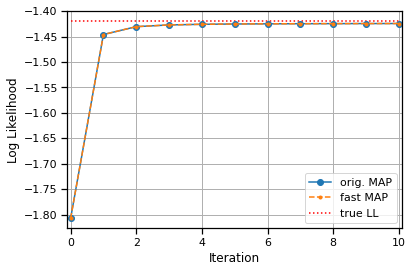

In [38]:
# Make random templates and set amplitude to zero
torch.manual_seed(0)
templates = generate_templates(N, D, K)
amplitudes = torch.zeros((K, T), device=device)
noise_std = 1.0
amp_rate = 5.0

# Copy to the device
templates = templates.to(device)
amplitudes = amplitudes.to(device)
data = data.to(device)

# Fit the model.
fast_lls = map_estimate_fast(templates, amplitudes, data, 
                             noise_std=noise_std, amp_rate=amp_rate)

# Plot the log likelihoods from the fast code on top of those from the 
# original code. They should like up exactly since we used the same 
# random seed for initialization.
fast_lls = fast_lls.to("cpu")
plt.plot(lls, '-o', label="orig. MAP")
plt.plot(fast_lls, '--.', label="fast MAP")
plt.hlines(true_ll, 0, len(lls) - 1, 
           colors='r', linestyles=':', label="true LL")
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.legend(loc="lower right")

assert torch.allclose(lls, fast_lls, atol=1e-4)

## Part 4: Try it on more realistic data

Last but not least, let's try it on some simulated data from eMouse &mdash; the software used to test Kilosort. This is a bit larger: 3.6x more samples and 2x more channels. We'll also be fitting 10x more neurons. The fast code you wrote in Problem 3 will make a big difference!

## Load preprocessed data

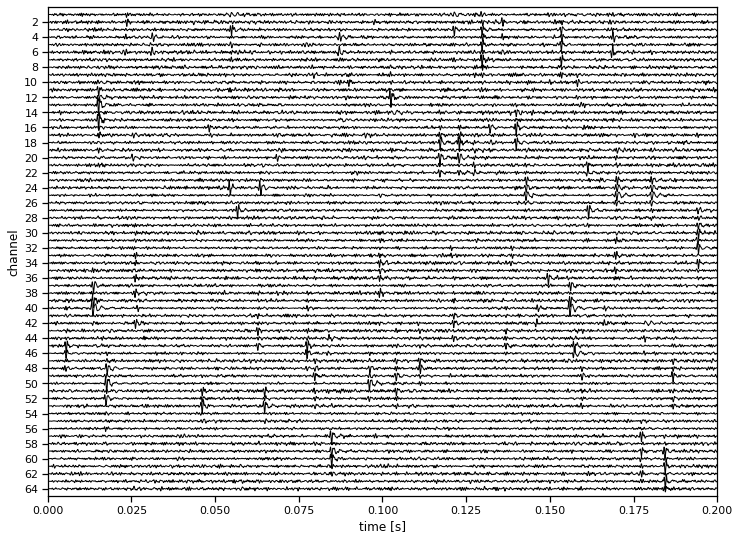

In [39]:
# Set some constants
data_dict = torch.load("lab1_data.pt")
sample_freq = 30000           # sampling frequency
spike_width = 81              # width of a spike, in samples
plot_slice = slice(0, 6000)   # 200ms window of frames to plot


# Load the data and plot it
data = data_dict["data"]
num_neurons = data_dict["num_neurons"]
num_channels, num_samples = data.shape
timestamps = torch.arange(num_samples) / sample_freq
plot_data(timestamps, data, scale=10, plot_slice=plot_slice)

### Fit the model using the fast MAP estimation code from Part 3
This should still take about 4.5 minutes when initialized with random templates. You could also initialize with the results from Lab 1; in fact, this is what Kilosort v1 did. (The latest version has a slightly different approach.) If you dare, try running the "slow" code from Part 2. It should be about 20x slower, so you saved an hour by implementing Part 3! 

In [40]:
# Initialize the templates randomly
torch.manual_seed(0)
templates = generate_templates(num_channels, spike_width, num_neurons)

# Copy to GPU
templates = templates.to(device)
amplitudes = torch.zeros(num_neurons, num_samples, device=device, dtype=torch.float32)
data = data.to(device)

# Fit the model.
lls = map_estimate_fast(templates, amplitudes, data, noise_std=1.0, amp_rate=10.0)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Convergence detected!


In [41]:
# # If you dare, run the "slow" code for comparison...
# templates = templates.to(device)
# amplitudes = torch.zeros(num_neurons, num_samples, device=device, dtype=torch.float32)
# data = data.to(device)
# lls = map_estimate(templates, amplitudes, data, noise_std=1.0, amp_rate=10.0)

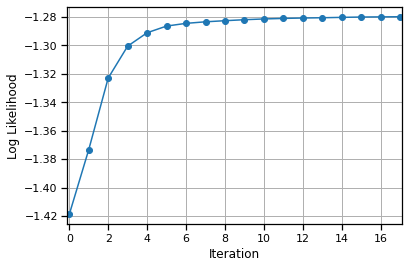

In [42]:
# Get the results off the GPU
lls = lls.to("cpu")
templates = templates.to("cpu")
amplitudes = amplitudes.to("cpu")
data = data.to("cpu")

# Plot the log likelihoods
plt.plot(lls.to("cpu"), '-o')
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)

### Plot the inferred templates

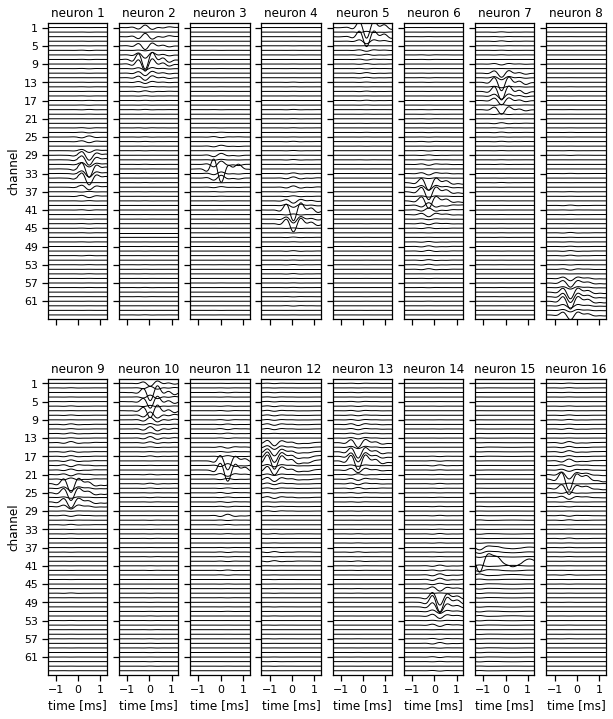

In [43]:
# Plot some templates (note, they're not ordered in any way)
_ = plot_templates(templates, torch.arange(16))

### Plot the data with inferred spikes overlaid
This doesn't show the ground truth, but you should see that the algorithm has picked up the major spikes in the voltage, and it has assigned similar spikes to the same neuron (colors). 

  0%|          | 0/100 [00:00<?, ?it/s]

Found 91369 putative spikes


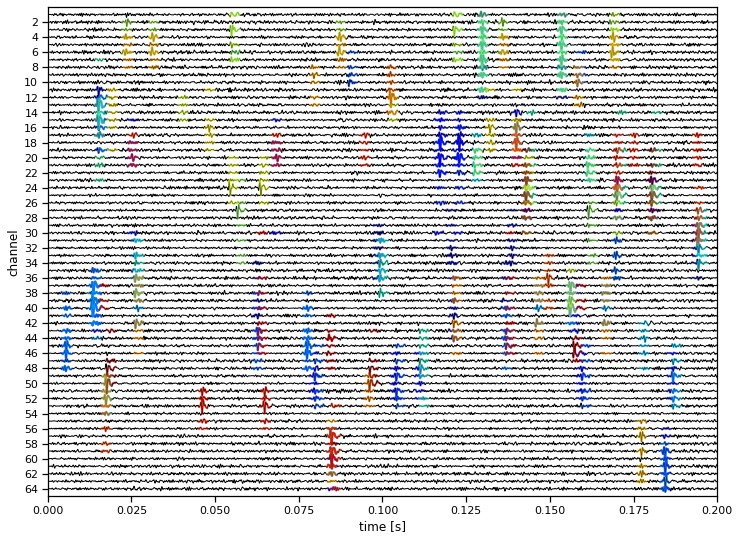

In [44]:
# Find the spike times and neuron labels
spike_times = []
labels = []
for neuron in trange(num_neurons):
    times = torch.where(amplitudes[neuron] > 0)[0]
    spike_times.append(times)
    labels.append(neuron * torch.ones(len(times), dtype=int))

spike_times = torch.cat(spike_times)
labels = torch.cat(labels)

# Find the channels that are significantly modulated in each template
neuron_channels = []
for template in templates:
    thresh = torch.quantile(abs(template), 0.975)
    neuron_channels.append(torch.any(abs(template) > thresh, axis=1))

print("Found {} putative spikes".format(len(spike_times)))

# Plot the data and overlay the inferred spikes
plot_data(timestamps, 
          data, 
          labels=labels, 
          spike_times=spike_times, 
          neuron_channels=neuron_channels, 
          spike_width=spike_width)

## Part 5: Short Answer


### Problem 5a:
In practice, you would post-process the extracted spikes to reject unrealistic neurons and merge overlapping ones. How would you approach this problem?


_Your answer here_

### Problem 5b:
Over the course of a long recording session, the probe could drift up and down so that the channels activated by a neuron shift. How could you compensate for this slow drift in this model, or possibly try to correct for it during preprocessing?



_Your answer here_

### Problem 5c
You may have noticed that we cheated in parts 2 and 3! We initialized our templates with the same random seed that was used to generate the synthetic data. What happens if you change that random seed? Can you come up with a heuristic to initialize the templates (without cheating and using the same random seed)?



_Your answer here_




### Problem 5d

How would your amplitude updates change if we replaced the exponential prior with a truncated normal prior,

$$
\begin{align*}
p(a_{k,t}) \propto \mathbb{I}[a_{k,t} \geq 0] \, \mathcal{N}(a_{k,t}; \mu, \nu^2).
\end{align*}
$$

Would this prior also shrink the estimates of the amplitude, and if so, how?

_Your answer here_

## Submission instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF. 

**Option 1 (best case): ipynb &rarr; pdf** Run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf lab1_teamname.ipynb
```

Unfortunately, `nbconvert` sometimes crashes with long notebooks. If that happens, here are a few options:


**Option 2 (next best): ipynb &rarr; tex &rarr; pdf**:
```
jupyter nbconvert --to latex lab1_teamname.ipynb
pdflatex lab1_teamname.tex
```

**Option 3: ipynb &rarr; html &rarr; pdf**:
```
jupyter nbconvert --to html lab1_teamname.ipynb
# open lab1_teamname.html in browser and print to pdf
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```
- `pdflatex`: It comes with standard TeX distributions like TeXLive, MacTex, etc. Alternatively, you can upload the .tex and supporting files to Overleaf (free with Stanford address) and use it to compile to pdf.

**Upload** your .ipynb and .pdf files to Gradescope. 

**Only one submission per team!**